In [1]:
!nvidia-smi

Sat Apr 27 06:41:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |   3569MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
!pip3 install scikit-cuda

    100% |████████████████████████████████| 122kB 3.9MB/s 


In [0]:
import numpy as np
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.fft as cu_fft

In [0]:
def fft2_gpu(x, fftshift=False):
    
    ''' This function produce an output that is 
    compatible with numpy.fft.fft2
    The input x is a 2D numpy array'''

    # Convert the input array to single precision float
    if x.dtype != 'float32':
        x = x.astype('float32')

    # Get the shape of the initial numpy array
    n1, n2 = x.shape
    
    # From numpy array to GPUarray
    xgpu = gpuarray.to_gpu(x)
    
    # Initialise output GPUarray 
    # For real to complex transformations, the fft function computes 
    # N/2+1 non-redundant coefficients of a length-N input signal.
    y = gpuarray.empty((n1,n2//2 + 1), np.complex64)
    
    # Forward FFT
    plan_forward = cu_fft.Plan((n1, n2), np.float32, np.complex64)
    cu_fft.fft(xgpu, y, plan_forward)
    
    left = y.get()

    # To make the output array compatible with the numpy output
    # we need to stack horizontally the y.get() array and its flipped version
    # We must take care of handling even or odd sized array to get the correct 
    # size of the final array   
    if n2//2 == n2/2:
        right = np.roll(np.fliplr(np.flipud(y.get()))[:,1:-1],1,axis=0)
    else:
        right = np.roll(np.fliplr(np.flipud(y.get()))[:,:-1],1,axis=0) 
    
    # Get a numpy array back compatible with np.fft
    if fftshift is False:
        yout = np.hstack((left,right))
    else:
        yout = np.fft.fftshift(np.hstack((left,right)))

    return yout.astype('complex128')

In [19]:
!pip3 install pydrive

    100% |████████████████████████████████| 993kB 24.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authentification Google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download du fichier

id = '1ANMkB5VwSmrDVEsi_87PP_In_HzrO03t'
downloaded = drive.CreateFile({'id': '1ANMkB5VwSmrDVEsi_87PP_In_HzrO03t'})
downloaded.GetContentFile('zebra.jpg')

In [21]:
!ls

adc.json  sample_data  zebra.jpg


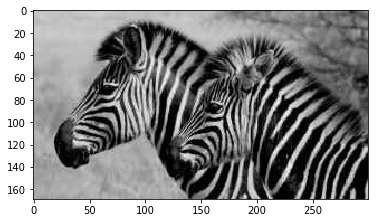

In [52]:
import matplotlib.pyplot as plt
from skimage import color

im = plt.imread('zebra.jpg').astype('uint16')
img = color.rgb2gray(im)
plt.imshow(img, cmap='gray')

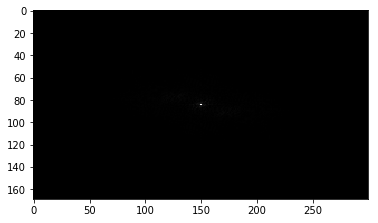

In [54]:
fft1 = np.fft.fftshift(np.fft.fft2(img))
fft2 = fft2_gpu(img, fftshift=True)
plt.imshow(np.abs(fft1),cmap='gray')

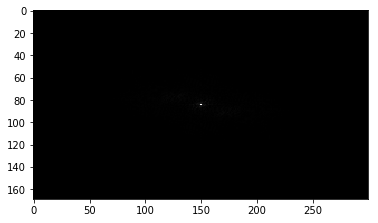

In [55]:
plt.imshow(np.abs(fft2),cmap='gray')

In [0]:
def ifft2_gpu(y, fftshift=False):

    ''' This function produce an output that is 
    compatible with numpy.fft.ifft2
    The input y is a 2D complex numpy array'''
    
    # Get the shape of the initial numpy array
    n1, n2 = y.shape
    
    # From numpy array to GPUarray. Take only the first n2/2+1 non redundant FFT coefficients
    if fftshift is False:
        y2 = np.asarray(y[:,0:n2//2 + 1], np.complex64)
    else:
        y2 = np.asarray(np.fft.ifftshift(y)[:,:n2//2+1], np.complex64)
    ygpu = gpuarray.to_gpu(y2) 
     
    # Initialise empty output GPUarray 
    x = gpuarray.empty((n1,n2), np.float32)
    
    # Inverse FFT
    plan_backward = cu_fft.Plan((n1, n2), np.complex64, np.float32)
    cu_fft.ifft(ygpu, x, plan_backward)
    
    # Must divide by the total number of pixels in the image to get the normalisation right
    xout = x.get()/n1/n2
    
    return xout

In [0]:
img1 = np.real(np.fft.ifft2(np.fft.ifftshift(fft1)))
img2 = ifft2_gpu(fft2, fftshift=True)

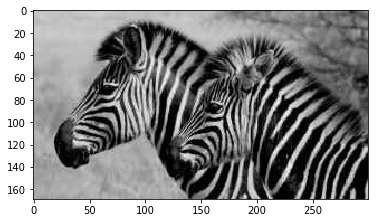

In [57]:
plt.imshow(img1, cmap='gray')

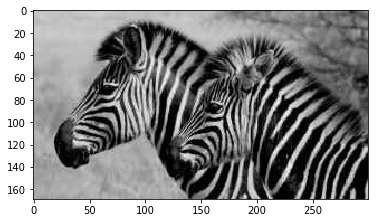

In [58]:
plt.imshow(img2, cmap='gray')